In [ ]:

import os, sys, itertools, re


if 'google.colab' in sys.modules:    
    project_path =  "/content/drive/My Drive/"
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append(project_path)
    %cd $project_path//

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2022-12-11 20:06:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.08s   

2022-12-11 20:06:51 (63.4 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
datastore

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
testing_padded.shape

(6709, 100)

In [ ]:
testing_labels.shape

(6709,)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(196, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 196)               3332      
                                                                 
 dense_1 (Dense)             (None, 1)                 197       
                                                                 
Total params: 163,529
Trainable params: 163,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels) ,verbose=2)

Epoch 1/10
625/625 - 5s - loss: 0.5949 - accuracy: 0.6582 - val_loss: 0.4126 - val_accuracy: 0.8225 - 5s/epoch - 8ms/step
Epoch 2/10
625/625 - 2s - loss: 0.3280 - accuracy: 0.8648 - val_loss: 0.4558 - val_accuracy: 0.7888 - 2s/epoch - 4ms/step
Epoch 3/10
625/625 - 2s - loss: 0.2510 - accuracy: 0.8988 - val_loss: 0.3604 - val_accuracy: 0.8480 - 2s/epoch - 4ms/step
Epoch 4/10
625/625 - 2s - loss: 0.2040 - accuracy: 0.9218 - val_loss: 0.3786 - val_accuracy: 0.8408 - 2s/epoch - 3ms/step
Epoch 5/10
625/625 - 2s - loss: 0.1742 - accuracy: 0.9329 - val_loss: 0.3823 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 6/10
625/625 - 2s - loss: 0.1478 - accuracy: 0.9444 - val_loss: 0.4118 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 7/10
625/625 - 2s - loss: 0.1275 - accuracy: 0.9535 - val_loss: 0.4502 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 8/10
625/625 - 2s - loss: 0.1128 - accuracy: 0.9595 - val_loss: 0.5528 - val_accuracy: 0.8247 - 2s/epoch - 3ms/step
Epoch 9/10
625/625 - 2s 

210/210 [==============================] - 0s 2ms/step


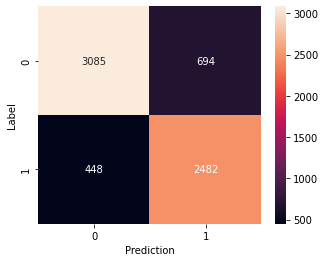

In [ ]:

# get model predictions for validation set
val_pred = model.predict(testing_padded)
val_pred = [1 if n >= 0.5 else 0 for n in val_pred]

# confusion matrix for validation prediction
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
confusion_mtx = tf.math.confusion_matrix(testing_labels, val_pred, num_classes=2) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(testing_labels, val_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      3779
           1       0.78      0.85      0.81      2930

    accuracy                           0.83      6709
   macro avg       0.83      0.83      0.83      6709
weighted avg       0.83      0.83      0.83      6709



In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


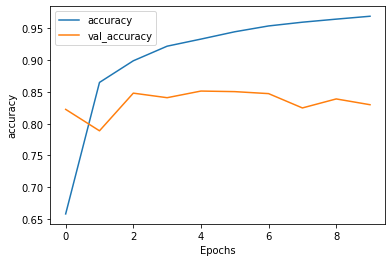

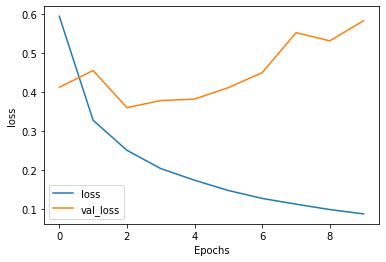

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = [
            "granny starting to fear spiders in the garden might be real",
            "the weather today is bright and sunny"
]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen=max_length,
                       padding=padding_type,
                       truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 19ms/step
[[9.6508658e-01]
 [3.5643537e-04]]


## LSTM##

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(128, return_sequences = True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5, input_shape = (256,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5, input_shape = (128,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5, input_shape = (64,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
callbacks=[es]
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         148480    
 l)                                                              
                                                                 
 global_average_pooling1d_1   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [ ]:
batch_size = 100
epochs = 6


history = model1.fit(training_padded, training_labels, epochs=epochs, validation_data=(testing_padded, testing_labels), verbose=2, batch_size = batch_size,callbacks = callbacks)

Epoch 1/6
200/200 - 9s - loss: 0.6473 - accuracy: 0.6150 - val_loss: 0.4899 - val_accuracy: 0.7982 - 9s/epoch - 46ms/step
Epoch 2/6
200/200 - 3s - loss: 0.4562 - accuracy: 0.8166 - val_loss: 0.4504 - val_accuracy: 0.8261 - 3s/epoch - 15ms/step
Epoch 3/6
200/200 - 3s - loss: 0.3621 - accuracy: 0.8849 - val_loss: 0.4417 - val_accuracy: 0.8310 - 3s/epoch - 15ms/step
Epoch 4/6
200/200 - 3s - loss: 0.3189 - accuracy: 0.9023 - val_loss: 0.4921 - val_accuracy: 0.7946 - 3s/epoch - 17ms/step
Epoch 5/6
200/200 - 4s - loss: 0.2955 - accuracy: 0.9133 - val_loss: 0.4489 - val_accuracy: 0.8325 - 4s/epoch - 19ms/step
Epoch 6/6
200/200 - 3s - loss: 0.2653 - accuracy: 0.9252 - val_loss: 0.5437 - val_accuracy: 0.8281 - 3s/epoch - 15ms/step


210/210 [==============================] - 2s 6ms/step


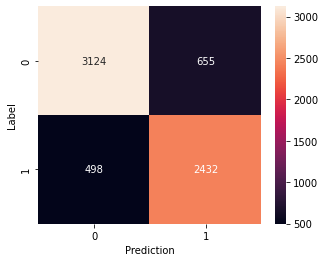

In [ ]:

# get model predictions for validation set
val_pred = model1.predict(testing_padded)
val_pred = [1 if n >= 0.5 else 0 for n in val_pred]

# confusion matrix for validation prediction
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
confusion_mtx = tf.math.confusion_matrix(testing_labels, val_pred, num_classes=2) 
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,precision_score, recall_score, roc_curve, precision_recall_curve 

In [ ]:
print(classification_report(testing_labels, val_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3779
           1       0.79      0.83      0.81      2930

    accuracy                           0.83      6709
   macro avg       0.83      0.83      0.83      6709
weighted avg       0.83      0.83      0.83      6709



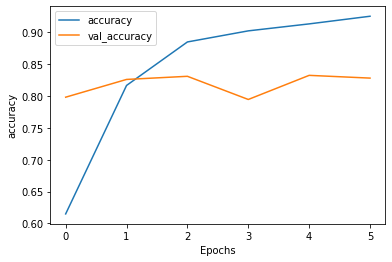

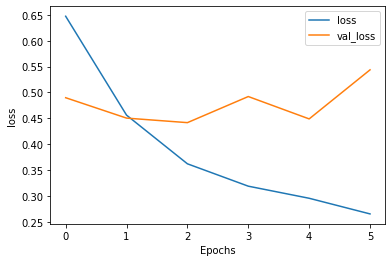

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 8.3 MB/s 
     |████████████████████████████████| 182 kB 72.2 MB/s 
     |████████████████████████████████| 7.6 MB 59.0 MB/s 


In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model1.predict(padded))

1/1 [==============================] - 0s 20ms/step
[[0.84772223]
 [0.8607683 ]]


##BERT##

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_json('Sarcasm_Headlines.json', lines=True)
labels = data.is_sarcastic.values
sentences = data.headline.values
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

#Train test split
train_sents,test_sents, train_labels, test_labels  = train_test_split(sentences,labels,test_size=0.15)

train_ids = encoder(train_sents)
test_ids = encoder(test_sents) 

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

Building Model from transformers using pre-trained bert-base-uncased (12-layer, 768-hidden, 12-heads, 110M parameters.)

In [ ]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 16)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             16, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
history = model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/3


710/710 [==============================] - 120s 147ms/step - loss: 0.3098 - accuracy: 0.8652 - val_loss: 0.2260 - val_accuracy: 0.9097
Epoch 2/3
710/710 [==============================] - 100s 140ms/step - loss: 0.1710 - accuracy: 0.9335 - val_loss: 0.1999 - val_accuracy: 0.9201
Epoch 3/3
710/710 [==============================] - 100s 141ms/step - loss: 0.1020 - accuracy: 0.9622 - val_loss: 0.2224 - val_accuracy: 0.9229


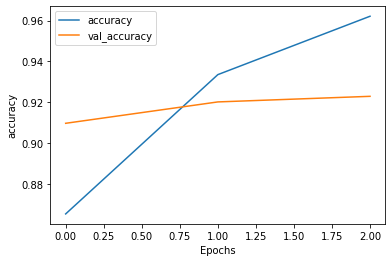

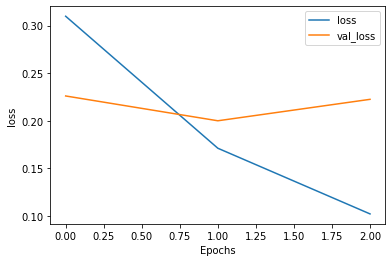

In [ ]:


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
model1 = model

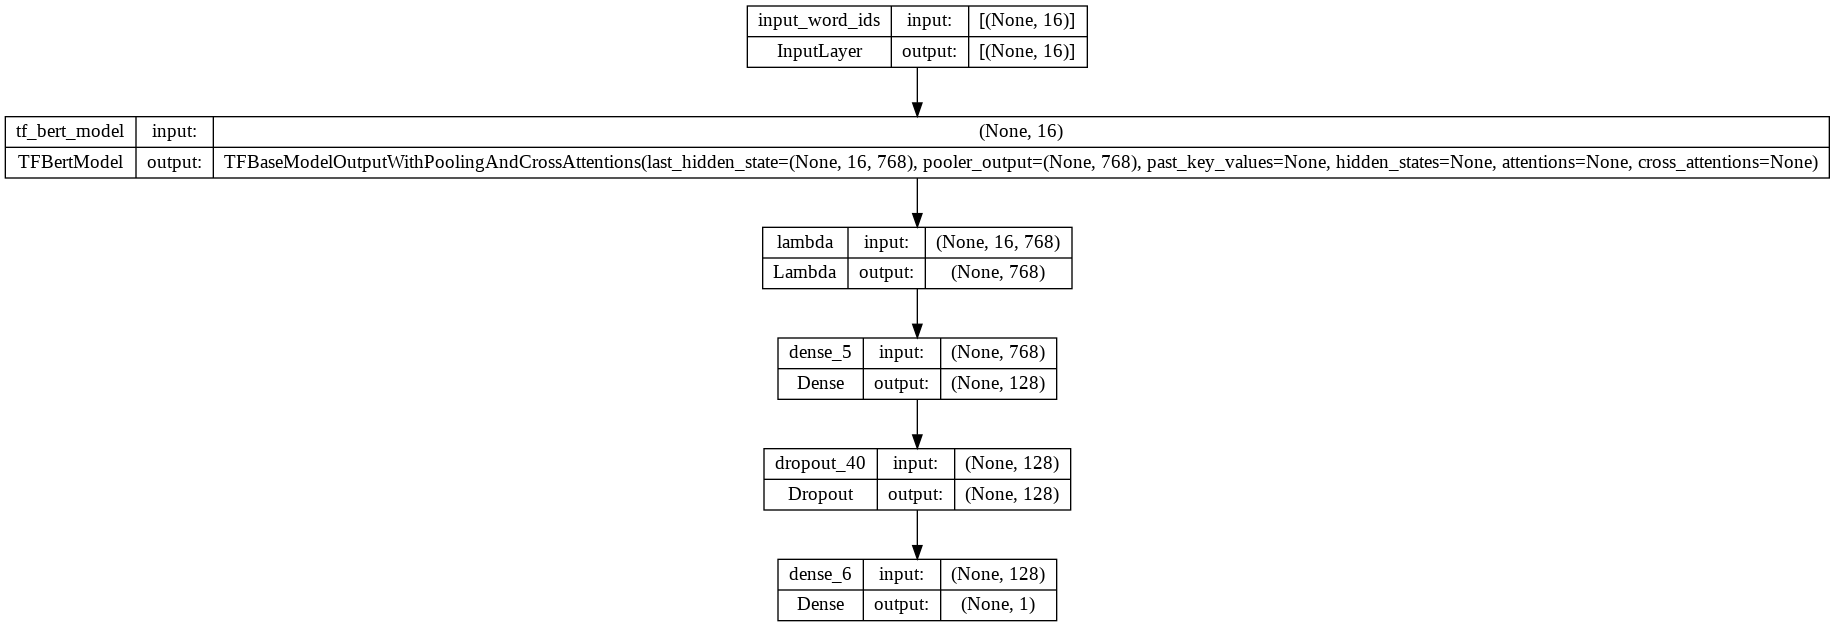

In [ ]:
from keras.utils.vis_utils import plot_model
# model = Sequential()
# model.add(Dense(2, input_dim=1, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
plot_model(model1, to_file='TFBertModel_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# (test_ids, test_labels))
# predict probabilities for test set
yhat_probs = model.predict(test_ids, verbose=0)
# predict crisp classes for test set
# yhat_classes = model.predict_classes(test_ids, verbose=0)

# source: https://stackoverflow.com/questions/38971293/get-class-labels-from-keras-functional-model
yhat_classes = yhat_probs.argmax(axis=-1)

print(yhat_probs[:3])
print(yhat_classes[:3])
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes

[[9.6356475e-01]
 [2.6160278e-04]
 [9.9945813e-01]]
[0 0 0]


In [ ]:
# https://stackoverflow.com/questions/55074681/how-to-find-the-wrong-predictions-in-keras
import numpy as np
# model.fit(x_nyha, y_nyha, batch_size=batch_size, epochs=num_epochs, verbose=1)
# prediction = np.round(model.predict(test_ids))
test_labels1 = tf.cast(test_labels, dtype='float')
yhat_probs1 = tf.convert_to_tensor(np.round(yhat_probs))
wrong_predictions = test_labels[yhat_probs1 != test_labels1]

In [ ]:
test_labels1[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 0., 1., 0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
yhat_probs1[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 0., 1., 0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
wrong_predictions[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0])>

In [ ]:
wrong_predictions

<tf.Tensor: shape=(309,), dtype=int64, numpy=
array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
     

In [ ]:
wrong_predictions_test_sents = test_sents[yhat_probs1 != test_labels1]
# wrong_predictions_test_ids_x = test_ids_x[yhat_probs1 != test_labels1]
wrong_predictions_test_ids = test_ids[yhat_probs1 != test_labels1]

In [ ]:
print(wrong_predictions_test_sents[:10])
# print(wrong_predictions_test_ids_x[:10])
print(wrong_predictions_test_ids[:10])

['toothbrush melts into oblivion in surprisingly hypnotic video'
 'secretarian violence claims lives of three receptionists'
 'greenspan comes out of retirement for one more interest rate hike'
 'martin luther king jr. day celebrates 30th anniversary'
 'trump raises concern over members of urban communities voting more than zero times'
 'white roof, low energy'
 'study finds exposure to violent children causes increased aggression in video game characters'
 'teen stops masturbating long enough to save family from fire'
 'kim jong un reopens long-closed border hotline with south korea'
 'wedding couple does lightsaber duel instead of first dance']
tf.Tensor(
[[  101 11868 18623 14899  2015  2046 24034  1999 10889 28322  2678   102
      0     0     0     0]
 [  101  3595 12199  4808  4447  3268  1997  2093 23775  2015   102     0
      0     0     0     0]
 [  101 15505  9739  3310  2041  1997  5075  2005  2028  2062  3037  3446
  21857   102     0     0]
 [  101  3235  9678  2332  3781

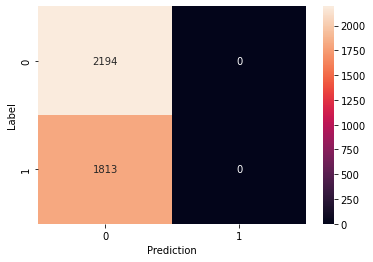

In [ ]:
confusion_mtx = tf.math.confusion_matrix(test_labels, yhat_classes)
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
def get_confusion_matrix_values(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

TP, FP, FN, TN = get_confusion_matrix_values(test_labels, yhat_classes)

In [ ]:
get_confusion_matrix_values(test_labels, yhat_classes)

(2194, 0, 1813, 0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_labels, yhat_classes, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.55      1.00      0.71      2194
    Sarcastic       0.00      0.00      0.00      1813

     accuracy                           0.55      4007
    macro avg       0.27      0.50      0.35      4007
 weighted avg       0.30      0.55      0.39      4007



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

model1.save_weights("model.h5")